# 初试 PyTorch 神经网络 - MNIST 分类

PyTorch 生成对抗式网络编程, 2020

In [1]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

## Mnist 数据集类

使用 PyTorch 的数据集类作为模板管理数据集

In [2]:
class MnistDataset(Dataset):
    """数据集的管理"""
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass


## 载入数据

In [3]:
mnist_dataset = MnistDataset('datasets/mnist_train.csv')

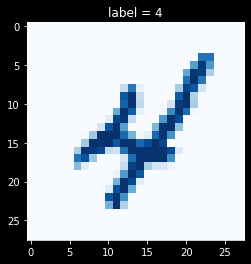

In [4]:
# 检测数据中包含的图像

mnist_dataset.plot_image(9)

In [5]:
# 通过索引检测数据集的类别，返回标签、图像值和目标张量

mnist_dataset[100]

(5,
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000,

## 神经网络的类

In [6]:
class Classifier(nn.Module):
    """使用全连接网络进行分类"""    
    def __init__(self):
        # 初始化 PyTorch 的基类
        super().__init__()
        
        # 定义神经网络的层
        self.model = nn.Sequential(
            nn.Linear(784, 200),    # 全连接层，784个输入，200个输出
            nn.Sigmoid(),        # 激活函数
            nn.Linear(200, 10),     # 全连接层，200个输入，10个输出
            nn.Sigmoid()        # 激活函数，其结果就是我们需要的分类结果
        )
        
        # 创建损失函数
        self.loss_function = nn.MSELoss()   # 均方误差损失：每个输出节点的实际输出与预期输出之差的平方和，再求均值

        # 创建优化器（使用 SGD，随机梯度下降），学习率为 0.01
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # 计数和累积进度
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # 简单的运行模型
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.forward(inputs)
        
        # 计算损失
        loss = self.loss_function(outputs, targets)

        # 每隔 10  个训练样本，计数器加 1
        self.counter += 1
        # 每隔 100 个训练样本，进度条更新一次，并将损失值记录到进度条中
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        # 每隔 10000 个训练样本，计数器输出一次
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # 梯度归零，反向传播，更新权重
        self.optimiser.zero_grad()  # 将计算图中的梯度全部归0，即参数初始化
        loss.backward()             # 从损失函数中反向传播梯度
        self.optimiser.step()       # 使用梯度更新网络参数
        # 注1：在每次训练之前都需要将梯度归零，否则梯度会累加
        # 注2：使用每次反向传播得到的梯度更新网络的参数

        pass
    
    
    def plot_progress(self):
        # 将损失值列表 progress 中的值转换为 pandas.DataFrame 对象
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

## 训练神经网络

In [7]:
%%time

C = Classifier()    # 创建分类器

# 基于 MNIST 数据集训练神经网络

epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor, target_tensor)
        pass
    pass

training epoch 1 of 4
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 4
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 4
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
training epoch 4 of 4
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
Wall time: 3min 14s


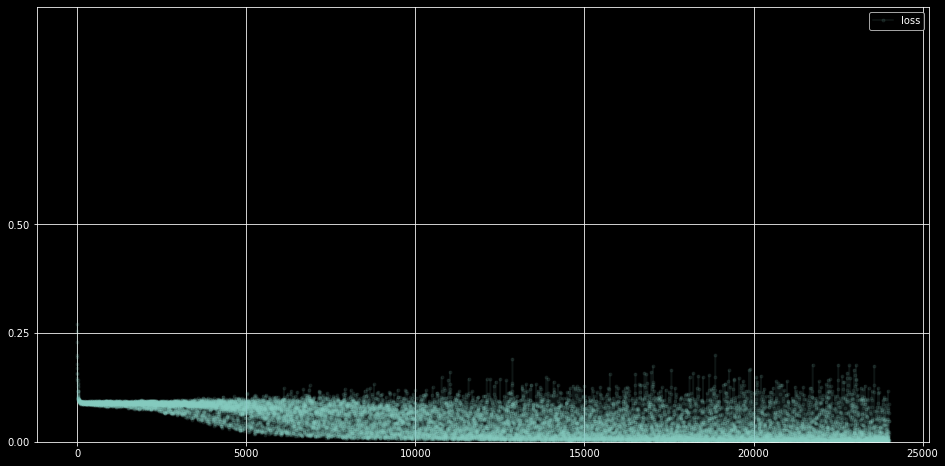

In [8]:
# 绘制分类器的效果
C.plot_progress()

## 分类器的样本

In [9]:
# 载入 MNIST 数据集中的测试数据
mnist_test_dataset = MnistDataset('datasets/mnist_test.csv')

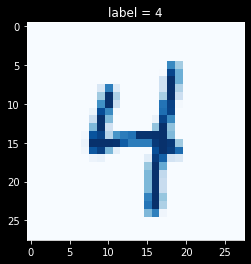

In [10]:
# 挑选一个数据记录
record = 19

# 绘制图像与标签
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

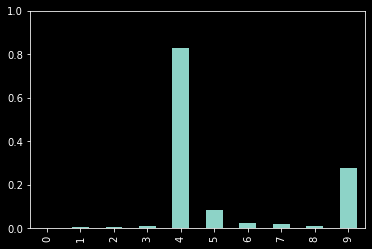

In [11]:
# 可视化神经网络输出的结果
image_data = mnist_test_dataset[record][1]

# 从训练后的网络中推理结果
output = C.forward(image_data)

# 绘制输出的图像
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))

## 分类器的性能

In [12]:
# 基于训练数据测试训练后的神经网络
score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1
    
    pass

print(score, items, score/items)

8799 10000 0.8799
